This notebook presents step by step implementation of a binary classifier for MNIST dataset, where we distinguish following classes(digits 0 and 1 are supposed to be removed from the dataset):
- Prime nubmers(2,3,5,7)
- Compound numbers(4,6,8,9)

The solution is going to:
 - Implement both **logistic regression** and optimization ***SGD + momentum*** using only **numpy**.
 - Tune the hyperparameters in order to increase the performance on test set.
 - Evaluate the model.



***Requirements:***
- python-mnist (Data reader)
- matplotlib
- seaborn
- numpy
- sklearn (for validation purposes only)

***Download MNIST***

(train set):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
 
(test set):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

***Unpack the data and rename the files***

 replace "." to "-" for all of the files names:  
   - **train-images.idx3-ubyte**   ->  **train-images-idx3-ubyte**  
   - **train-labels.idx1-ubyte**   ->  **train-labels-idx1-ubyte**  
   - **10k-images.idx3-ubyte.gz**   ->  **10k-images-idx3-ubyte.gz**  
   - **10k-labels.idx1-ubyte.gz**   ->  **10k-labels-idx1-ubyte.gz**  



In [1]:
#Imports
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
%config IPCompleter.greedy=True

#Data
mndata = MNIST('C:/Users/45502/my_notebooks')  #input valid path pointing unpacked and renamed MNIST dataset 

In [9]:
def process_data(train_imgs: list, train_labels: list, test_imgs: list,
                 test_labels: list, train_size: list, test_size: list):
    
    '''
    Method to process the MNIST data
    
    Parameters:
    
    train_imgs, train_labels : Train data to be processed
    test_imgs, test_labels : Test data to be processed
    train_size : number of samples in the train set
        if train_size = None, method returns all of the samples
    test_size : number of samples in the test set
        if train_size = None, method returns all of the samples
    
    Returns:
    
    X (np.array) : processed train_imgs
    y (np.array) : processed train_labels
    test_X (np.array) : processed test_imgs
    test_y (np.array) : processed test_labels
    
    '''
   
    prime_nums = [2,3,5,7]

    #Remove 0 from train data
    train_zero_indicies= [index for index, element in enumerate(train_labels) if element == 0]
    for index in sorted(train_zero_indicies, reverse=True):
        del train_imgs[index]
        del train_labels[index]

    #Remove 0 from test data
    test_zero_indicies= [index for index, element in enumerate(test_labels) if element == 0]
    for index in sorted(test_zero_indicies, reverse=True):
        del test_imgs[index]
        del test_labels[index]

    #Remove 1 from train data
    train_one_indicies= [index for index, element in enumerate(train_labels) if element == 1]
    for index in sorted(train_one_indicies, reverse=True):
        del train_imgs[index]
        del train_labels[index]

    #Remove 1 from test data
    test_one_indicies= [index for index, element in enumerate(test_labels) if element == 1]
    for index in sorted(test_one_indicies, reverse=True):
        del test_imgs[index]
        del test_labels[index]

    #Separation between 0 - prime numbers and  1 - compound numbers
    for index,val  in enumerate (train_labels):
        if val in prime_nums:
            train_labels[index] = 0
        else:
            train_labels[index] = 1

    for index,val  in enumerate (test_labels):
        if val in prime_nums:
            test_labels[index] = 0
        else:
            test_labels[index] = 1


    #Convert to numpy
    X = np.array (train_imgs)
    y = np.array (train_labels)

    test_X =  np.array(test_imgs)
    test_y = np.array(test_labels)
    
    #If not None -> Takes train_size number of samples from train set
    if train_size != None:
        X=X[:train_size]
        y=y[:train_size] 
    
   #If not None -> Takes train_size number of samples from test set
    if test_size != None:
        test_X=test_X[:test_size]
        test_y=test_y[:test_size]


    y = y.reshape((y.shape[0],1))
    test_y = test_y.reshape((test_y.shape[0],1))
    

    
    #Number of samples for given dataset
    m = len(y)
    test_m = len(test_y)

    #Adding intercept term
    X = np.hstack((np.ones((m,1)),X))
    test_X = np.hstack((np.ones((test_m,1)),test_X))

    n = np.size(X,1)
    

    #Normalization
    X = (X - np.min(X)) / ((np.max(X) - np.min(X)))
    test_X = (test_X - np.min(test_X)) / (np.max(test_X) - np.min(test_X))
    
    return X, y, test_X, test_y

In [10]:
class Model:
    '''Model for logistic regression'''
    
    params = None
    
    def __init__(self, learning_rate: float, momentum_rate: float):
        
        ''' 
        Init fucntion setting learning rate and momentum of the model object
        
        Parameters:
        learning_rate: the value of the learning rate
        momentum_rate: the value of the momentum rate
        
        '''
        
        self.learning_rate = learning_rate
        self.momentum_rate = momentum_rate
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        '''Train model and set the parameters to the ones returned from SGD'''
        
        iterations = X.shape[0] * 8
        include_cost = False
        plot_precision = 0
        self.params = SGD(X, y, None, None, self.learning_rate, self.momentum_rate, iterations, include_cost, plot_precision)[2]

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''Predict the label of the class
        
        Returns:
        predicted labels
        
        '''
        pred = sigmoid(X@self.params)
        pred = pred>=0.5
        
        return pred.astype(int)
    

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        ''' 
        Evalutes the predicted classes
        Returns:
        accuracy: accuracy of the model
        '''
        errors_num =  np.sum(y_true != y_pred)
        accuracy =  1 - errors_num / y_true.shape[0] 
        return accuracy


h = sigmoid(X*theta);

J = (sum ( ( -y .* log(h)) - ((1-y) .*(log(1-h) )) ) ) /m;
sum()

In [57]:
#Funkcja sigmoid
def sigmoid(z: float):
    """
    Calculates sigmoid of z
    
    Returns:
    sigmoid of z
    
    """
    
    return 1 / ( 1 + np.exp(-z) )


def compute_cost(X: np.array, y: np.array, theta: np.array):
    '''
    Calucaltes the cost of the function
    
    Returns:
    Cost of the function
    
    '''
    
    m = X.shape[0]
    h = sigmoid(X @ theta)
    cost = - np.average(y * np.log(h) + (1 - y) * np.log(1 - h))
    
    return cost

In [58]:
def SGD(X: np.array, y: np.array, test_X: np.array, test_y: np.array, learning_rate: float, momentum_rate: float,
                 iterations: int, include_cost: bool, cost_precision: int):
    '''
    Stochasit gradient descent

    Optimization of the parameters in order to find the min cost of the function

    Parameters:
    X (np.array) : train data
    y (np.array) : train labels
    test_X (np.array) : test data
    test_y (np.array) : test labels
    learning_rate: the value of the learning rate
    momentum_rate: the value of the momentum rate
    
    Returns:
    test_cost_history: cost history of the test set 
    train_cost_history: cost history of the train set
    params: best function parameters for min cost
    '''
    
    # cost history and samples num initialization
    test_cost_history = np.zeros((iterations,1))
    train_cost_history = np.zeros((iterations,1))
    m = len(y)
    n = np.size(X,1)
    this_velocity = np.zeros((n,1))
    
    params =  np.ones((n,1))/4
    
    for i in range(iterations):
        
        #TODO: add decaying learning rate
        
        #TODO: add bias correction        
        #         if bias_correction:
        #             ''' early stage bias reduction for momentum'''
        #             bias_correct = 1 - (momentum_rate**(i+1) )
        #             this_velocity = this_velocity * (1/ bias_correct)


        #Reset index after each epoch
        sample_index = i%m
        
        #Sample extraction
        current_X = X[sample_index].reshape((1,X.shape[1]))
        current_y = y[sample_index]
        
        #Inference for current parameters
        h =sigmoid(current_X@params)
        
        #Gradient
        grad = learning_rate* (current_X.T @  (h- current_y) )
        
        #Update momentum
        this_velocity = momentum_rate *  this_velocity + grad 
        
        #Update params
        params -= this_velocity 
        
        #Cost for current parameters
        if include_cost:
            #For big dataset we will save every cost_precision
            if i %cost_precision == 0:
                test_cost_history[i] = compute_cost(test_X, test_y, params)
                train_cost_history[i] = compute_cost(X, y, params)
            else:
                test_cost_history[i] = test_cost_history[i-1]
                train_cost_history[i] =  train_cost_history[i-1]

    return (test_cost_history, train_cost_history, params)

In [64]:
def hyperparameters_tunning(iterations: int, X: np.array, y: np.array, test_X, test_y, initial_lr: float, steps_lr: int,
                            delta_lr: float, initial_mr: float, steps_mr: int, delta_mr: float, visualize: bool):
    '''
    Circulates around the initial learning rate and momementum rate in order to find their best values.
    
    It changes it`s values by delta_lr/mr and does it steps_lr/mr times.
    
    Parameters:
    X (np.array) : train data
    y (np.array) : train labels
    test_X (np.array) : test data
    test_y (np.array) : test labels
    initial_lr: the initial learning rate
    steps_lr: number of iterations learning rate
    delta_lr: change of the learning rate per iteration
    initial_mr: the initial momentum rate
    steps_mr: number of iterations momentum rate
    delta_mr: change of the momentum rate per iteration
    visualize: whether to plot the graph or not
    
    Returns:
    hyper_parameters_cost_results: history of all of the costs
    min_cost: minimal cost
    best_lr: the best learning rate
    best_mr: the best momentum rate
    '''
    min_cost = 1000
    best_lr = None
    best_mr = None
    n  = np.size(X,1)
    #Historia z wewnątrz SGD i jego iteracji
    include_cost_history=False
    hyper_parameters_cost_results = np.ones((steps_lr,steps_mr))*97
    
    for learning_iter in range(steps_lr):
        learning_rate = initial_lr + learning_iter*delta_lr
        
        for momentum_iter in range(steps_mr):
            momentum_rate = initial_mr - momentum_iter * delta_mr
            
            params_optimal =  SGD(X, y, test_X, test_y, learning_rate, momentum_rate,
                                                                       iterations, include_cost_history, 0)[2]
            
            test_final_cost = compute_cost(test_X, test_y, params_optimal)
            
            if test_final_cost < min_cost:
                min_cost = test_final_cost
                best_lr = learning_rate
                best_mr = momentum_rate
            
            hyper_parameters_cost_results[learning_iter,momentum_iter] = test_final_cost
            color = np.random.rand(3,)        
#         if visualize:
#             plt.legend()
#             plt.show()

   
    return hyper_parameters_cost_results, min_cost, best_lr, best_mr

In [63]:
#SGD  momentum tunning
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)

iterations = X.shape[0] * 2 

initial_lr = 0.0005
steps_lr = 15
delta_lr = 0.00025

initial_mr = 0.702
steps_mr = 3
delta_mr = -0.07

visualize = False
hist,min_cost,lr,mr = hyperparameters_tunning(iterations, X, y, test_X, test_y, initial_lr, steps_lr,
                            delta_lr, initial_mr, steps_mr, delta_mr, visualize)
print ('SGD MOMENTUM')
print ('min cost is', min_cost)
print('best learning rate is',lr)
print('best momentum rate is', mr)

SGD MOMENTUM
min cost is 0.24751628647315704
best learning rate is 0.00075
best momentum rate is 0.702


In [49]:
#SGD  bez momentum dla całego datasetu z tuneowanymi parametrami
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)
iterations = X.shape[0] * 8 
lr = 0.0005
mr = 0
include_cost_history = False
cost_history_ratio = 0
params_optimal =  SGD(X, y, test_X, test_y, lr, mr,  iterations, include_cost_history, cost_history_ratio)[2]
cost =  compute_cost(test_X, test_y, params_optimal)

print("SGD ZWYKŁY Z DOBRANYMI PARAMETRAMI")
print ('KOŃCOWY KOSZT DLA CAŁEGO TEST SETU:', cost)


SGD ZWYKŁY Z DOBRANYMI PARAMETRAMI
KOŃCOWY KOSZT DLA CAŁEGO TEST SETU: 0.24321118847971873


In [50]:
#SGD  momentum dla całego datasetu z tuneowanymi parametrami
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)
iterations = X.shape[0] * 8 
lr = 0.0005
mr = 0.9
include_cost_history = False
cost_history_ratio = 0
params_optimal =  SGD(X, y, test_X, test_y, lr, mr,  iterations, include_cost_history, cost_history_ratio)[2]
cost =  compute_cost(test_X, test_y, params_optimal)

print("SGD MOMENTUM Z DOBRANYMI PARAMETRAMI")
print ('KOŃCOWY KOSZT DLA CAŁEGO TEST SETU:', cost)


SGD MOMENTUM Z DOBRANYMI PARAMETRAMI
KOŃCOWY KOSZT DLA CAŁEGO TEST SETU: 0.25032441017763946


In [52]:
#Calculate convergence 
#Care cause cost for each iteration is retunerd here

train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()

train_X, train_y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, 22000, 2000)
iterations = X.shape[0] * 1 
lr = 0.001 #Learning reate
mr = 0.9   #Momentum rate
include_cost_history = True
cost_history_ratio = 2 # This will calculate cost for both train and test set every cost_history_iteration

comparison = {}
comparison['regular'] =SGD(train_X, train_y, test_X, test_y, lr, 0,  iterations, include_cost_history, cost_history_ratio)
comparison['momentum'] =SGD(train_X, train_y, test_X, test_y, lr, mr,  iterations, include_cost_history, cost_history_ratio)




c:\program files\python37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


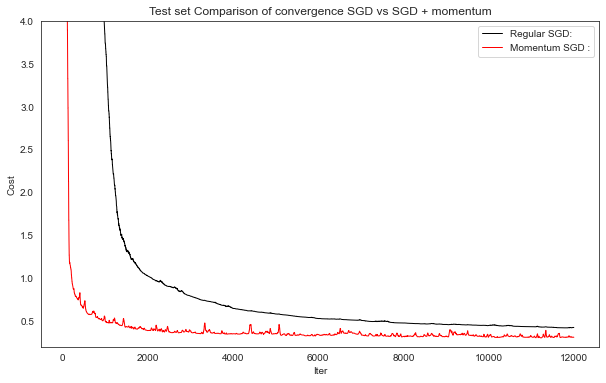

In [65]:
plt.figure(figsize=(10,6))
plt.title('Test set Comparison of convergence SGD vs SGD + momentum')
sns.set_style('white')
plt.xlabel("Iter")
plt.ylabel("Cost")

plt.plot( comparison['regular'][0], 'r',linewidth=1, label="Regular SGD:", color='black' )
plt.plot( comparison['momentum'][0] ,'r',linewidth=1, label="Momentum SGD :", color='red' )

plt.ylim(0.2,4)
plt.legend()
plt.show()


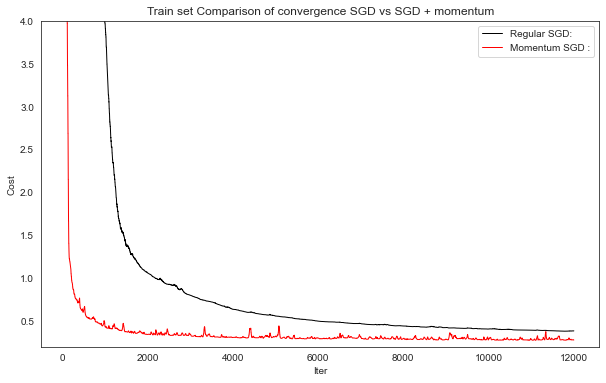

In [66]:
plt.figure(figsize=(10,6))
plt.title('Train set Comparison of convergence SGD vs SGD + momentum')
sns.set_style('white')
plt.xlabel("Iter")
plt.ylabel("Cost")

plt.plot( comparison['regular'][1], 'r',linewidth=1, label="Regular SGD:", color='black' )
plt.plot( comparison['momentum'][1] ,'r',linewidth=1, label="Momentum SGD :", color='red' )

plt.ylim(0.2,4)
plt.legend()
plt.show()


In [11]:
#Model initialization
#LR = Model(0.0005, 0.77)

#Data reading
train_imgs, train_labels = mndata.load_training()
test_imgs, test_labels = mndata.load_testing()
X, y, test_X, test_y = process_data(train_imgs, train_labels, test_imgs, test_labels, None, None)

# #Train
# LR.fit(X,y)

# #Evaluation
# y_pred = LR.predict(test_X)
# acc = LR.evaluate(y_pred,test_y)
# print ("Accuracy is :", acc*100, "%")w

In [12]:
X.shape

(47335, 785)

In [8]:
train_imgs

AttributeError: 'list' object has no attribute 'size'

In [64]:
#There is not class inbalance in this dataset
from sklearn.metrics import precision_recall_fscore_support
print (precision_recall_fscore_support.__doc__)
precision_recall_fscore_support(test_y, y_pred, average=None)
#print()

Compute precision, recall, F-measure and support for each class

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The F-beta score can be interpreted as a weighted harmonic mean of
    the precision and recall, where an F-beta score reaches its best
    value at 1 and worst score at 0.

    The F-beta score weights recall more than precision by a factor of
    ``beta``. ``beta == 1.0`` means recall and precision are equally important.

    The support is the number of occurrences of each class in ``y_true``.

    If ``pos_label is None`` and in 

(array([0.94444444, 0.88274389]),
 array([0.8753155 , 0.94799898]),
 array([0.90856694, 0.91420846]),
 array([3962, 3923], dtype=int64))

In [15]:
print (sum (test_y == 0))
print (sum (test_y == 1))

[3962]
[3923]


In [16]:
print (sum (y == 0))
print (sum (y == 1))

[23775]
[23560]
